In [1]:
import pandas as pd
import math

Read original file

In [2]:
# Replace 'your_file.csv' with the path to your CSV file
file_path = './datathon_2024_dataset_corrected.csv'


# Read the CSV file into a pandas DataFrame
original_df = pd.read_csv(file_path)

# Only keep home_team or away_team equals HOU
astro_df = original_df.loc[(original_df['home_team'] == 'HOU') | (original_df['away_team'] == 'HOU')]

print(astro_df.head())

    Unnamed: 0  game_date home_team away_team  is_day_game  home_score  \
19          19   20000404       PIT       HOU        False           2   
32          32   20000405       PIT       HOU        False           2   
46          46   20000406       PIT       HOU         True          10   
57          57   20000407       HOU       PHI        False           1   
72          72   20000408       HOU       PHI         True           8   

    away_score  venue            venue_name        city  ... away_hbp  \
19           5  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
32          11  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
46           1  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
57           4  HOU03      Minute Maid Park     Houston  ...        0   
72           5  HOU03      Minute Maid Park     Houston  ...        1   

    home_pa  home_1b  home_2b  home_3b  home_hr  home_fo  home_so  home_bb  \
19       36        5        0        0

Read location file

In [3]:
location_file_path = './cities_coordinates.xlsx'
location_df = pd.read_excel(location_file_path)
print(location_df.head())

         city  latitude  longitude
0     Atlanta   33.7490   -84.3880
1  Cincinnati   39.1031   -84.5120
2       Miami   25.7617   -80.1918
3    Montreal   45.5017   -73.5673
4    New York   40.7128   -74.0060


Function to calculate the distance with latitudes and longitudes.

In [4]:
# Calculate the distance between two points.

def haversine(lat1, lon1, lat2, lon2):
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine公式
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # 地球半径（单位：公里）
    radius = 6371.0

    # 计算距离
    distance = radius * c

    return distance

# 示例：两个地点的经纬度
lat1, lon1 = 37.7749, -122.4194  # 地点1（例如，旧金山）
lat2, lon2 = 34.0522, -118.2437  # 地点2（例如，洛杉矶）

# 计算距离
result = haversine(lat1, lon1, lat2, lon2)
print(f"distance is：{result:.2f} ")


distance is：559.12 


Delete outlier cities.

In [5]:
#print out all city names

# Delelete all rows with city "Tokyo", "London", "Sydney",  "San Juan", "Monterrey"
astro_df = astro_df[astro_df['city'] != 'Tokyo']
astro_df = astro_df[astro_df['city'] != 'London']
astro_df = astro_df[astro_df['city'] != 'Sydney']
astro_df = astro_df[astro_df['city'] != 'San Juan']
astro_df = astro_df[astro_df['city'] != 'Monterrey']

# print(original_df['city'].unique())

# Count the number of unique city
# print(original_df['city'].nunique())



Add location to original file.

In [6]:
import pandas as pd

# Assuming both venue_name columns are of the same data type


# Merge the two DataFrames based on 'venue_name'
merged_df = pd.merge(astro_df, location_df, on='city', how='inner')

# 'inner' will keep only the rows where venue_name exists in both tables

# Display the merged DataFrame

# Sort merged_df by game_date
merged_df = merged_df.sort_values(by='game_date')
print(merged_df.head(20))



      Unnamed: 0  game_date home_team away_team  is_day_game  home_score  \
0             19   20000404       PIT       HOU        False           2   
1             32   20000405       PIT       HOU        False           2   
2             46   20000406       PIT       HOU         True          10   
114           57   20000407       HOU       PHI        False           1   
115           72   20000408       HOU       PHI         True           8   
116           87   20000409       HOU       PHI         True           2   
117           99   20000410       HOU       SLN        False           7   
118          107   20000411       HOU       SLN        False           6   
119          119   20000412       HOU       SLN        False           7   
1999         150   20000414       SDN       HOU        False           4   
2000         163   20000415       SDN       HOU        False           5   
2001         179   20000416       SDN       HOU         True          13   
2055        

Calculate distance from last game.

In [7]:
# Add a column distance to the merged_df. Calculate the distance between the city in this row and the city in last row.
# If the city in this row is the first city, then the distance is 0.
# Use the function haversine() to calculate the distance.
merged_df['distance'] = 0
for i in range(1, len(merged_df)):
    merged_df['distance'].iloc[i] = haversine(merged_df['latitude'].iloc[i-1], merged_df['longitude'].iloc[i-1], merged_df['latitude'].iloc[i], merged_df['longitude'].iloc[i])



/var/folders/4h/m7zq6dq13nvdg2z667851n9h0000gn/T/ipykernel_24436/3300626854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['distance'].iloc[i] = haversine(merged_df['latitude'].iloc[i-1], merged_df['longitude'].iloc[i-1], merged_df['latitude'].iloc[i], merged_df['longitude'].iloc[i])


In [8]:
# change game_date to datetime
merged_df['game_date'] = pd.to_datetime(merged_df['game_date'], format='%Y%m%d')

Modelling distance factor

In [9]:
# Add a column days_after travel
merged_df['days_after_travel'] = 0

# From the second row, if hou_distance equals zero, add one to days_after_travel. If not, set days_after_travel to zero.
for index, row in merged_df.iterrows():
    if index == 0:
        continue
    else:
        if merged_df.loc[index, 'distance'] == 0:
            merged_df.loc[index, 'days_after_travel'] = merged_df.loc[index - 1, 'days_after_travel'] + 1
        else:
            merged_df.loc[index, 'days_after_travel'] = 0

In [10]:
# Use initial_factor * np.exp(-0.5 * days_after_travel) to calculate the fatigue factor
import numpy as np
# The initial factor is distance / 1000 + the fatigue factor in last row
merged_df['distance_factor'] = 0
merged_df['distance_factor'].iloc[0] = merged_df['distance'].iloc[0] / 1000
for index, row in merged_df.iterrows():
    if index == 0:
        continue
    else:
        initial_factor = merged_df.loc[index - 1, 'distance_factor'] + merged_df.loc[index, 'distance'] / 1000
        merged_df.loc[index, 'distance_factor'] = initial_factor * np.exp(-0.5 * merged_df.loc[index, 'days_after_travel'])

print(merged_df[["home_team", "away_team", "distance", "days_after_travel", "distance_factor"]].head(30))

/var/folders/4h/m7zq6dq13nvdg2z667851n9h0000gn/T/ipykernel_24436/310635331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['distance_factor'].iloc[0] = merged_df['distance'].iloc[0] / 1000


     home_team away_team     distance  days_after_travel  distance_factor
0          PIT       HOU     0.000000                  0         0.000000
1          PIT       HOU     0.000000                  1         0.000000
2          PIT       HOU     0.000000                  2         0.000000
114        HOU       PHI  1829.889838                  0         1.829890
115        HOU       PHI     0.000000                  1         1.109884
116        HOU       PHI     0.000000                  2         0.408304
117        HOU       SLN     0.000000                  3         0.091105
118        HOU       SLN     0.000000                  4         0.012330
119        HOU       SLN     0.000000                  5         0.001012
1999       SDN       HOU  2093.853720                  0         2.093854
2000       SDN       HOU     0.000000                  1         1.269986
2001       SDN       HOU     0.000000                  2         0.467202
2055       LAN       HOU   179.410425 

In [11]:
# plot a graph showing home_team_distance over time of the team 'HOU'(home_team or away_team)
import matplotlib.pyplot as plt


# Use plotly to plot the graph
import plotly.express as px

fig = px.line(merged_df, x='game_date', y='distance_factor', title='Distance factor for HOU')
fig.show()


Add rest time and consecutive days of playing

In [12]:
from datetime import timedelta  # Import the timedelta class

# Function to calculate last rest day and consecutive playing days
def calculate_playing_info(team_games):
    sorted_dates = sorted(team_games)
    rest_days = {}
    consecutive_days = {}
    last_date = None
    consecutive_count = 0

    for date in sorted_dates:
        if last_date and date - last_date == timedelta(days=1):
            consecutive_count += 1
        else:
            consecutive_count = 1

        if last_date and date - last_date > timedelta(days=1):
            rest_day = date - timedelta(days=1)
        else:
            rest_day = None

        rest_days[date] = rest_day
        consecutive_days[date] = consecutive_count
        last_date = date

    return rest_days, consecutive_days

# Create a dictionary to store all game dates for each team
team_games = {}
for index, row in merged_df.iterrows():
    for team in [row['home_team'], row['away_team']]:
        if team not in team_games:
            team_games[team] = []
        team_games[team].append(row['game_date'])

# Calculate rest days and consecutive playing days for each team
team_info = {team: calculate_playing_info(dates) for team, dates in team_games.items()}

# Update the DataFrame with the calculated data
for index, row in merged_df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    game_date = row['game_date']

    # Update info for home team
    merged_df.at[index, 'home_last_rest_day'] = team_info[home_team][0].get(game_date)
    merged_df.at[index, 'home_consecutive_playing_days'] = team_info[home_team][1].get(game_date)

    # Update info for away team
    merged_df.at[index, 'away_last_rest_day'] = team_info[away_team][0].get(game_date)
    merged_df.at[index, 'away_consecutive_playing_days'] = team_info[away_team][1].get(game_date)

In [13]:
# Iterate through rows, if HOU is home_team, extract home_consecutive_playing_days, if HOU is away_team, extract away_consecutive_playing_days
# Add all consecutive_playing_days to a column hou_consecutive_playing_days
merged_df['hou_consecutive_playing_days'] = 0
for index, row in merged_df.iterrows():
    if row['home_team'] == 'HOU':
        merged_df.loc[index, 'hou_consecutive_playing_days'] = row['home_consecutive_playing_days']
    else:
        merged_df.loc[index, 'hou_consecutive_playing_days'] = row['away_consecutive_playing_days']



In [14]:
# print only title of table

print(merged_df.columns.values)

['Unnamed: 0' 'game_date' 'home_team' 'away_team' 'is_day_game'
 'home_score' 'away_score' 'venue' 'venue_name' 'city' 'state' 'away_pa'
 'away_1b' 'away_2b' 'away_3b' 'away_hr' 'away_fo' 'away_so' 'away_bb'
 'away_hbp' 'home_pa' 'home_1b' 'home_2b' 'home_3b' 'home_hr' 'home_fo'
 'home_so' 'home_bb' 'home_hbp' 'latitude' 'longitude' 'distance'
 'days_after_travel' 'distance_factor' 'home_last_rest_day'
 'home_consecutive_playing_days' 'away_last_rest_day'
 'away_consecutive_playing_days' 'hou_consecutive_playing_days']


In [15]:
print(merged_df[["game_date", "home_team", "away_team", "hou_consecutive_playing_days"]].head(50))

      game_date home_team away_team  hou_consecutive_playing_days
0    2000-04-04       PIT       HOU                             1
1    2000-04-05       PIT       HOU                             2
2    2000-04-06       PIT       HOU                             3
114  2000-04-07       HOU       PHI                             4
115  2000-04-08       HOU       PHI                             5
116  2000-04-09       HOU       PHI                             6
117  2000-04-10       HOU       SLN                             7
118  2000-04-11       HOU       SLN                             8
119  2000-04-12       HOU       SLN                             9
1999 2000-04-14       SDN       HOU                             1
2000 2000-04-15       SDN       HOU                             2
2001 2000-04-16       SDN       HOU                             3
2055 2000-04-18       LAN       HOU                             1
2056 2000-04-19       LAN       HOU                             2
120  2000-

Add jet lag

In [16]:
from timezonefinder import TimezoneFinder
import pytz
from datetime import datetime

# Function to get the timezone from latitude and longitude
def get_timezone(latitude, longitude):
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=latitude, lng=longitude)
    return timezone_str

# Function to calculate the time difference between two timezones
def calculate_time_diff(tz1, tz2):
    if not tz1 or not tz2:
        return 0
    current_time = datetime.utcnow()
    tz1_time = pytz.timezone(tz1).localize(current_time)
    tz2_time = pytz.timezone(tz2).localize(current_time)
    return int((tz1_time.utcoffset() - tz2_time.utcoffset()).total_seconds() / 3600)

# Precompute timezones for each unique location
unique_locations = merged_df[['latitude', 'longitude']].drop_duplicates()
unique_locations['timezone'] = unique_locations.apply(lambda row: get_timezone(row['latitude'], row['longitude']), axis=1)
location_timezones = dict(zip(unique_locations[['latitude', 'longitude']].apply(tuple, axis=1), unique_locations['timezone']))

# Initialize the jet lag columns
merged_df['home_team_jet_lag'] = 0
merged_df['away_team_jet_lag'] = 0

# Dictionary to keep track of the last location of each team
last_locations_timezones = {}

# Iterate through each row in the DataFrame
for index, row in merged_df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    current_location = (row['latitude'], row['longitude'])
    current_timezone = location_timezones[current_location]

    # Calculate jet lag for home team
    if home_team in last_locations_timezones:
        last_timezone = last_locations_timezones[home_team]
        merged_df.at[index, 'home_team_jet_lag'] = calculate_time_diff(current_timezone, last_timezone)
    last_locations_timezones[home_team] = current_timezone

    # Calculate jet lag for away team
    if away_team in last_locations_timezones:
        last_timezone = last_locations_timezones[away_team]
        merged_df.at[index, 'away_team_jet_lag'] = calculate_time_diff(current_timezone, last_timezone)
    last_locations_timezones[away_team] = current_timezone



In [17]:
# Iterate through rows, if HOU is home_team, extract home_consecutive_playing_days, if HOU is away_team, extract away_consecutive_playing_days
# Add all consecutive_playing_days to a column hou_consecutive_playing_days
merged_df['hou_jet_lag'] = 0
for index, row in merged_df.iterrows():
    if row['home_team'] == 'HOU':
        merged_df.loc[index, 'hou_jet_lag'] = row['home_team_jet_lag']
    else:
        merged_df.loc[index, 'hou_jet_lag'] = row['away_team_jet_lag']



In [18]:
# output a csv file
merged_df.to_csv('travel_analysis_astro.csv', index=False)

In [19]:
import pandas as pd

# Replace 'your_file_path.xlsx' with the actual path to your Excel file
file_path = './travel_analysis_astro.csv'

# Load the data
data = pd.read_csv(file_path)

# Multiply the 'distance_factor' column by 1000
data['distance_factor'] = data['distance_factor'] * 1000

# Display the first few rows to verify the changes
# print(data[['distance_factor']].head(50))


    distance_factor
0          0.000000
1          0.000000
2          0.000000
3       1829.889838
4       1109.884291
5        408.303613
6         91.104850
7         12.329701
8          1.012083
9       2093.853720
10      1269.986478
11       467.201916
12       179.410425
13       108.817923
14      2207.276112
15      1338.780636
16       492.509872
17       109.893807
18        14.872509
19         1.220810
20      1618.872293
21       981.895680
22       361.219234
23        80.598906
24       131.055603
25        79.489242
26        29.242458
27      2912.789430
28      1766.696095
29       649.931172
30      2207.484838
31      1338.907235
32       492.556445
33       109.904199
34        14.873916
35         1.220925
36         0.060786
37      1699.471198
38      1172.349177
39       711.065720
40       261.586460
41      2871.820375
42      1741.847107
43      1618.933079
44       981.932548
45       361.232797
46        80.601932
47        10.908285
48         0.895407


In [28]:
# calculating the average point value of each specific time period (cities)

# Iterate through rows, if HOU is home_team, extract home_consecutive_playing_days, if HOU is away_team, extract away_consecutive_playing_days
# Add all consecutive_playing_days to a column hou_consecutive_playing_days
merged_df['HOU_score'] = 0
for index, row in merged_df.iterrows():
    if row['home_team'] == 'HOU':
        merged_df.loc[index, 'HOU_score'] = row['home_score']
    else:
        merged_df.loc[index, 'HOU_score'] = row['away_score']



In [29]:
# Delete all rows with distance equals zero
merged_df = merged_df[merged_df['distance'] != 0]
print(merged_df[["distance",'HOU_score']].head(50))



         distance  HOU_score
114   1829.889838          1
1999  2093.853720         10
2055   179.410425          3
120   2206.264028          2
2112  1618.872293          7
2230   131.055603          1
2057  2803.971507          2
126   2206.264028          1
2116  1618.872293          5
2379  1172.349177          2
2117  1172.349177          9
133   1618.872293         10
2397  1413.644844          7
139   1413.644844          4
2060  2206.264028          2
2002   179.410425          7
2400  1340.249516          6
2455  1524.503301          4
145   2643.045853          6
2506  1632.166882          1
2573  2043.754052          4
151   1094.099848          4
2681  1779.654964          2
2720   145.133104          5
157   1793.140904          0
2759  1436.875034          7
2861   595.451920          2
2908   975.883024          4
162   1556.794499          7
2957  2156.270867          7
169   2156.270867         16
2382  2582.330426          3
3003   533.688483          2
178   2281.344

In [30]:
# calculating the average point of the HOU_score just received

import pandas as pd

def calculate_hou_avg_point(df):
    # Create a helper column to identify blocks
    df['block'] = (df['distance'] != 0).cumsum()

    # Calculating average score for each block
    avg_scores = df.groupby('block')['HOU_score'].mean()

    # Mapping the average scores back to the original dataframe
    df['HOU_AvgPoint'] = df['block'].map(avg_scores)

    # Optionally, remove the helper column if it's no longer needed
    df.drop('block', axis=1, inplace=True)

    return df

# Replace 'your_file_path.csv' with the path of your CSV file
#file_path = './travel_analysis_astro.csv'
#df = pd.read_csv(file_path)

# Apply the function to your dataframe
merged_df = calculate_hou_avg_point(merged_df)

# Display the first few rows of the updated dataframe
print(merged_df[['distance', 'HOU_score', 'HOU_AvgPoint']].head(20))

# Optionally, save the modified dataframe back to a CSV
# df.to_csv('modified_file.csv', index=False)


         distance  HOU_score  HOU_AvgPoint
114   1829.889838          1           1.0
1999  2093.853720         10          10.0
2055   179.410425          3           3.0
120   2206.264028          2           2.0
2112  1618.872293          7           7.0
2230   131.055603          1           1.0
2057  2803.971507          2           2.0
126   2206.264028          1           1.0
2116  1618.872293          5           5.0
2379  1172.349177          2           2.0
2117  1172.349177          9           9.0
133   1618.872293         10          10.0
2397  1413.644844          7           7.0
139   1413.644844          4           4.0
2060  2206.264028          2           2.0
2002   179.410425          7           7.0
2400  1340.249516          6           6.0
2455  1524.503301          4           4.0
145   2643.045853          6           6.0
2506  1632.166882          1           1.0


In [36]:
# output a csv file
merged_df.to_csv('travel_analysis_astro.csv', index=False)

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the data
file_path = './travel_analysis_astro.csv'
data = pd.read_csv(file_path)

# Create a 'score_diff' column that reflects the margin of victory or defeat for the Houston Astros
data['score_diff'] = data.apply(lambda row: row['home_score'] - row['away_score'] if row['home_team'] == 'HOU' else row['away_score'] - row['home_score'], axis=1)
data['home_run'] = data.apply(lambda row: row['home_hr'] if row['home_team'] == 'HOU' else row['away_hr'], axis=1)
data['home_1b'] = data.apply(lambda row: row['home_1b'] if row['home_team'] == 'HOU' else row['away_1b'], axis=1)
data['home_2b'] = data.apply(lambda row: row['home_2b'] if row['home_team'] == 'HOU' else row['away_2b'], axis=1)
data['home_3b'] = data.apply(lambda row: row['home_3b'] if row['home_team'] == 'HOU' else row['away_3b'], axis=1)

# Fill missing values with zeros
data = data.fillna(0)

# Select features and the target variable
features = ['distance']
X = data[features]
y = data['HOU_AvgPoint']


# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Model coefficients
coefficients = model.coef_

# Output the RMSE and coefficients
rmse, coefficients


(3.262989891910429, array([-0.07916624]))

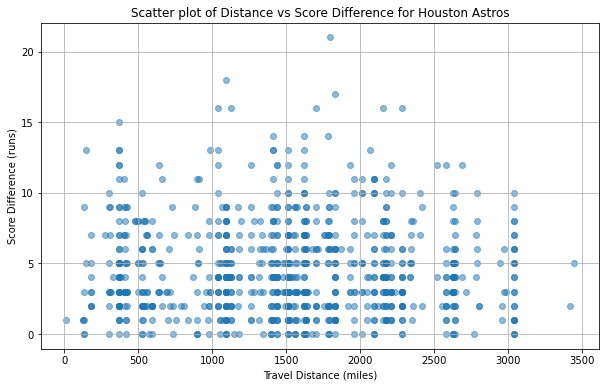

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting scatter points of 'distance' vs. 'score_diff'
plt.figure(figsize=(10, 6))
plt.scatter(data['distance'], data['HOU_AvgPoint'], alpha=0.5)
plt.title('Scatter plot of Distance vs Score Difference for Houston Astros')
plt.xlabel('Travel Distance (miles)')
plt.ylabel('Score Difference (runs)')
plt.grid(True)
plt.show()


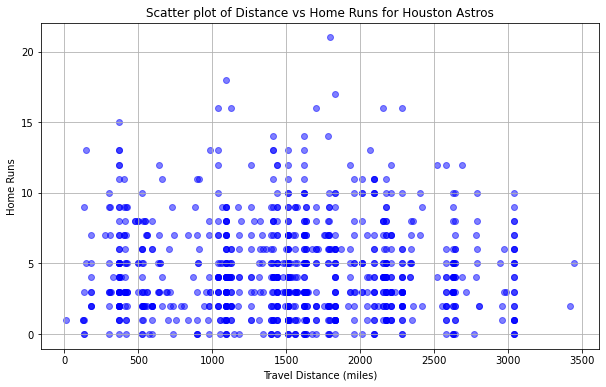

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting scatter points of 'distance' vs. 'home_run'
plt.figure(figsize=(10, 6))
plt.scatter(X['distance'], y, alpha=0.5, color='blue')
plt.title('Scatter plot of Distance vs Home Runs for Houston Astros')
plt.xlabel('Travel Distance (miles)')
plt.ylabel('Home Runs')
plt.grid(True)
plt.show()